In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Load data

In [4]:
routes_counts = pd.read_csv('./Data/Taipei_Metro_Route_hourly_2019-202106.csv')

In [5]:
routes_counts['Date'] = pd.to_datetime(routes_counts['Date'])
routes_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252135281 entries, 0 to 252135280
Data columns (total 5 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      datetime64[ns]
 1   Hour      int64         
 2   Entrance  object        
 3   Exit      object        
 4   Counts    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.4+ GB


In [6]:
stations = pd.read_csv('./Data/Taipei_Metro_Stations_geo.csv')
stations.head()

,Code,Station,Line,Line2,Cross_Lines,Lines_Transfer,Transportation,station_name_en,address,lat,lon
0,BL01,頂埔,BL,N,0,0,0,Dingpu,新北市土城區中央路四段51-6號B3,24.960120,121.420500
1,BL02,永寧,BL,N,0,0,0,Yongning,新北市土城區中央路三段105號B1,24.966726,121.436072
2,BL03,土城,BL,N,0,0,0,Tucheng,新北市土城區金城路一段105號B1,24.973094,121.444362
3,BL04,海山,BL,N,0,0,0,Haishan,新北市土城區海山路39號B2,24.985339,121.448786
4,BL05,亞東醫院,BL,N,0,0,0,Far Eastern Hospital,新北市板橋區南雅南路二段17號B1,24.998037,121.452514


In [7]:
stationmap = {name: stations.at[i,'Code'] for i, name in stations['Station'].items()}

In [8]:
traveltime = pd.read_csv('./Data/Taipei_Metro_Route_Traveltime_v2.csv')
traveltime = traveltime.drop_duplicates().reset_index(drop=True)
traveltime['DrivingTime'] = traveltime['DrivingTime(s)']/60
traveltime.tail()

,StationA,StationB,Code_StationA,Code_StationB,From_To,TravelTime,From_lat,From_lon,To_lat,To_lon,DrivingTime(s),Distance(m),DrivingTime
14037,新北產業園區,中原,Y20,Y14,Y20_Y14,17,25.061548,121.459926,25.008410,121.484159,853,7526,14.216667
14038,新北產業園區,板新,Y20,Y15,Y20_Y15,14,25.061548,121.459926,25.014491,121.472212,743,5664,12.383333
14039,新北產業園區,Y板橋,Y20,Y16,Y20_Y16,11,25.061548,121.459926,25.015156,121.464825,834,5833,13.900000
14040,新北產業園區,新埔民生,Y20,Y17,Y20_Y17,8,25.061548,121.459926,25.026125,121.466839,542,4217,9.033333
14041,新北產業園區,幸福,Y20,Y19,Y20_Y19,3,25.061548,121.459926,25.050282,121.460216,360,1667,6.000000


## Clean & Process

### Station

In [9]:
def get_groupby_entrance(df):
    output = df.pivot_table(values='Counts', index=['Date','Hour','Entrance'], aggfunc=np.sum).reset_index()
    output['DayofWeek'] = output['Date'].dt.dayofweek
    output['Weekend'] = output['DayofWeek'].isin([5,6])
    return output

In [10]:
def get_hour_comparison(df):
    output = df.pivot_table(values='Counts', index='Entrance', columns='Hour', aggfunc=np.mean).reset_index()
    return output

In [11]:
def get_weekend_comparison(df):
    output = df.pivot_table(values='Counts', index='Entrance', columns='Weekend', aggfunc=np.mean).reset_index().rename(columns={False:'Normal', True:'Weekend'})
    return output

In [12]:
def station_transfer(df1, df2, df3):
    output = get_hour_comparison(df1).merge(get_hour_comparison(df2), how='left', on='Entrance', suffixes=('_before','_covid')).merge(get_hour_comparison(df3), how='left', on='Entrance')
    weekend = get_weekend_comparison(df1).merge(get_weekend_comparison(df2), how='left', on='Entrance', suffixes=('_before','_covid')).merge(get_weekend_comparison(df3), how='left', on='Entrance')
    output = output.merge(weekend, how='left', on='Entrance')
    output = output.merge(stations.loc[:,['Station','Cross_Lines','Lines_Transfer','Transportation']], how='left', left_on='Entrance', right_on='Station')
    return output

In [13]:
df1 = routes_counts[routes_counts['Date'] < datetime.strptime('2020-01-01','%Y-%m-%d')]
df2 = routes_counts[(routes_counts['Date'] >= datetime.strptime('2020-01-01','%Y-%m-%d')) & (routes_counts['Date'] < datetime.strptime('2021-01-15','%Y-%m-%d'))]
df3 = routes_counts[routes_counts['Date'] >= datetime.strptime('2021-01-15','%Y-%m-%d')]

In [14]:
df1['Date'].max(), df2['Date'].max(), df3['Date'].max()

(Timestamp('2019-12-31 00:00:00'),
 Timestamp('2021-01-14 00:00:00'),
 Timestamp('2021-06-30 00:00:00'))

In [15]:
del routes_counts

In [16]:
stations_data = station_transfer(get_groupby_entrance(df1), get_groupby_entrance(df2), get_groupby_entrance(df3))
stations_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 108
Data columns (total 77 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entrance        109 non-null    object 
 1   0_before        109 non-null    float64
 2   1_before        109 non-null    float64
 3   5_before        109 non-null    float64
 4   6_before        109 non-null    float64
 5   7_before        109 non-null    float64
 6   8_before        109 non-null    float64
 7   9_before        109 non-null    float64
 8   10_before       109 non-null    float64
 9   11_before       109 non-null    float64
 10  12_before       109 non-null    float64
 11  13_before       109 non-null    float64
 12  14_before       109 non-null    float64
 13  15_before       109 non-null    float64
 14  16_before       109 non-null    float64
 15  17_before       109 non-null    float64
 16  18_before       109 non-null    float64
 17  19_before       109 non-null    flo

In [17]:
stations_data.drop(columns=['1_before','1_covid',1,2,3,4,'Station'], inplace=True)
stations_data.head()

,Entrance,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,...,23,Normal_before,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,Cross_Lines,Lines_Transfer,Transportation
0,BL板橋,250.830137,0.796703,450.493151,2073.060274,4672.868493,2890.098630,2104.756164,2062.369863,2148.265753,...,434.796407,1966.093431,2132.342491,1713.237671,1675.849647,1307.711885,1137.889881,0,1,1
1,七張,47.273973,0.274725,304.983562,1239.495890,2218.731507,1409.109589,1004.479452,982.695890,924.224658,...,115.317365,842.855292,684.992674,777.914481,579.101852,617.407363,454.081349,0,0,0
2,三和國中,40.167123,0.222527,400.865753,1414.887671,2520.246575,1294.317808,807.295890,688.441096,631.073973,...,75.497006,630.872628,485.808150,589.754809,412.730600,475.903561,324.095238,0,0,0
3,三民高中,32.723288,0.197802,365.800000,1354.471233,2390.808219,1231.717808,786.947945,679.638356,628.715068,...,65.616766,599.459854,477.956044,557.694823,397.710758,453.007603,318.475198,0,0,0
4,三重,59.698630,0.101648,113.263014,546.969863,940.802740,510.079452,319.139726,324.416438,337.819178,...,75.832335,325.404015,343.150183,301.586219,261.637125,249.176471,209.933532,0,0,1


### Routes

In [18]:
def get_groupby_route(df):
    output = df.pivot_table(values='Counts', index=['Date','Hour','Entrance','Exit'], aggfunc=np.sum).reset_index()
    output['DayofWeek'] = output['Date'].dt.dayofweek
    output['Weekend'] = output['DayofWeek'].isin([5,6])
    output = output[output['Entrance'] != output['Exit']]
    return output

In [19]:
def get_route_hour_comparison(df):
    output = df.pivot_table(values='Counts', index=['Entrance','Exit'], columns='Hour', aggfunc=np.mean).reset_index()
    output['From_To'] = output['Entrance'].map(stationmap) + '_' + output['Exit'].map(stationmap)
    output.drop(columns=['Entrance','Exit'], inplace=True)
    return output

In [20]:
def get_route_weekend_comparison(df):
    output = df.pivot_table(values='Counts', index=['Entrance','Exit'], columns='Weekend', aggfunc=np.mean).reset_index().rename(columns={False:'Normal', True:'Weekend'})
    output['From_To'] = output['Entrance'].map(stationmap) + '_' + output['Exit'].map(stationmap)
    output.drop(columns=['Entrance','Exit'], inplace=True)
    return output

In [21]:
def route_transfer(df1, df2, df3):
    output = get_route_hour_comparison(df1).merge(get_route_hour_comparison(df2), how='left', on='From_To', suffixes=('_before','_covid')).merge(get_route_hour_comparison(df3), how='left', on='From_To')
    weekend = get_route_weekend_comparison(df1).merge(get_route_weekend_comparison(df2), how='left', on='From_To', suffixes=('_before','_covid')).merge(get_route_weekend_comparison(df3), how='left', on='From_To')
    output = output.merge(weekend, how='left', on='From_To')
    output = output.merge(traveltime.loc[:,['From_To','StationA','StationB','TravelTime','DrivingTime','Distance(m)']], how='left', on='From_To')
    return output

In [22]:
routes_data = route_transfer(get_groupby_route(df1), get_groupby_route(df2), get_groupby_route(df3))
routes_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11556 entries, 0 to 11555
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0_before        11556 non-null  float64
 1   1_before        11556 non-null  float64
 2   5_before        11556 non-null  float64
 3   6_before        11556 non-null  float64
 4   7_before        11556 non-null  float64
 5   8_before        11556 non-null  float64
 6   9_before        11556 non-null  float64
 7   10_before       11556 non-null  float64
 8   11_before       11556 non-null  float64
 9   12_before       11556 non-null  float64
 10  13_before       11556 non-null  float64
 11  14_before       11556 non-null  float64
 12  15_before       11556 non-null  float64
 13  16_before       11556 non-null  float64
 14  17_before       11556 non-null  float64
 15  18_before       11556 non-null  float64
 16  19_before       11556 non-null  float64
 17  20_before       11556 non-null 

In [23]:
routes_data.drop(columns=['1_before','1_covid',1,2,3,4], inplace=True)
routes_data.head()

,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,13_before,...,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,StationA,StationB,TravelTime,DrivingTime,Distance(m)
0,2.408219,0.0,2.750685,13.142466,19.715068,9.739726,6.345205,6.367123,6.219178,6.934247,...,8.759158,4.744316,4.446208,3.380152,2.882937,BL板橋,七張,29,20.200000,13542
1,2.315068,0.0,0.468493,0.805479,4.397260,2.928767,2.109589,2.424658,2.852055,3.649315,...,7.198260,4.308499,5.213404,3.126050,2.701389,BL板橋,三和國中,32,20.900000,16150
2,3.139726,0.0,0.238356,1.794521,2.306849,2.627397,2.627397,2.704110,3.043836,3.547945,...,6.936813,4.436341,5.216931,3.136054,2.861111,BL板橋,三民高中,36,23.066667,12839
3,0.564384,0.0,0.309589,0.504110,1.871233,1.249315,1.758904,1.452055,1.350685,1.660274,...,2.426740,0.462399,0.817901,0.328131,0.415675,BL板橋,三重,28,16.316667,7797
4,1.561644,0.0,0.306849,0.830137,2.145205,2.189041,1.895890,2.315068,2.830137,2.882192,...,6.576465,3.636411,4.643298,2.593437,2.589286,BL板橋,三重國小,30,18.900000,9468


## K-means

### Station Cluster Analysis

In [24]:
X = stations_data.iloc[:,1:]
X.head()

,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,13_before,...,23,Normal_before,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,Cross_Lines,Lines_Transfer,Transportation
0,250.830137,0.796703,450.493151,2073.060274,4672.868493,2890.098630,2104.756164,2062.369863,2148.265753,2270.958904,...,434.796407,1966.093431,2132.342491,1713.237671,1675.849647,1307.711885,1137.889881,0,1,1
1,47.273973,0.274725,304.983562,1239.495890,2218.731507,1409.109589,1004.479452,982.695890,924.224658,994.550685,...,115.317365,842.855292,684.992674,777.914481,579.101852,617.407363,454.081349,0,0,0
2,40.167123,0.222527,400.865753,1414.887671,2520.246575,1294.317808,807.295890,688.441096,631.073973,631.150685,...,75.497006,630.872628,485.808150,589.754809,412.730600,475.903561,324.095238,0,0,0
3,32.723288,0.197802,365.800000,1354.471233,2390.808219,1231.717808,786.947945,679.638356,628.715068,638.369863,...,65.616766,599.459854,477.956044,557.694823,397.710758,453.007603,318.475198,0,0,0
4,59.698630,0.101648,113.263014,546.969863,940.802740,510.079452,319.139726,324.416438,337.819178,355.786301,...,75.832335,325.404015,343.150183,301.586219,261.637125,249.176471,209.933532,0,0,1


In [25]:
distortions, silhouette_avg = [], []
for i in range(2,11):
    km = KMeans(n_clusters=i)
    km_fit = km.fit(X)
    distortions.append(km.inertia_)
    silhouette_avg.append(silhouette_score(X, km_fit.labels_))

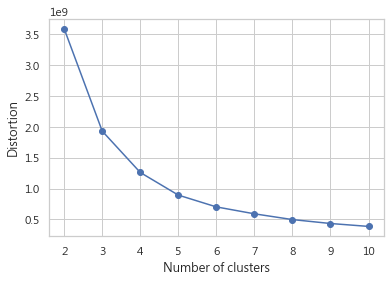

In [26]:
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

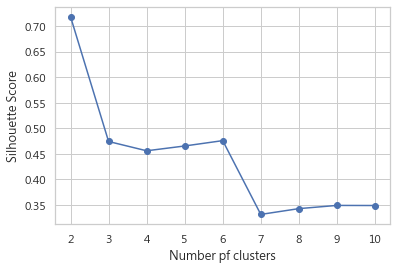

In [27]:
plt.plot(range(2,11), silhouette_avg, marker='o')
plt.xlabel('Number pf clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [28]:
km = KMeans(n_clusters=6)
y_km = km.fit_predict(X)

In [29]:
for i in set(y_km):
    print(i,len(X[y_km==i]))

0 59
1 7
2 1
3 14
4 26
5 2


In [30]:
stations_data['cluster_label'] = y_km

In [31]:
stations_data[stations_data['cluster_label'] == 2]

,Entrance,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,...,Normal_before,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,Cross_Lines,Lines_Transfer,Transportation,cluster_label
32,台北車站,1513.257534,2.252747,1090.243836,4468.265753,10121.849315,8543.350685,7467.934247,7906.106849,8571.706849,...,7275.418796,8565.61859,5883.803603,6356.044092,4499.158063,4580.81746,1,1,1,2


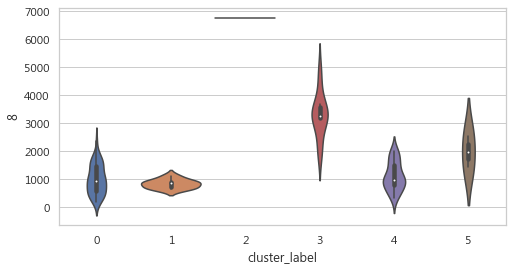

In [36]:
mpl.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(8,4))
sns.violinplot(x=stations_data['cluster_label'], y=stations_data.loc[:,8])
plt.show()

In [39]:
stations_data[stations_data['cluster_label'] == 3]

,Entrance,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,...,Normal_before,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,Cross_Lines,Lines_Transfer,Transportation,cluster_label
0,BL板橋,250.830137,0.796703,450.493151,2073.060274,4672.868493,2890.098630,2104.756164,2062.369863,2148.265753,...,1966.093431,2132.342491,1713.237671,1675.849647,1307.711885,1137.889881,0,1,1,3
11,亞東醫院,63.715068,0.489011,575.731507,2271.972603,4217.441096,2334.175342,1539.115068,1390.682192,1346.934247,...,1271.694343,836.394231,1179.037251,683.737654,954.348539,548.250000,0,0,0,3
24,南勢角,67.643836,0.434066,609.515068,2243.747945,4531.082192,2388.923288,1445.526027,1257.331507,1117.613699,...,1097.284854,882.344780,985.412032,715.496914,794.724290,576.916667,0,0,0,3
26,南港展覽館,78.104110,0.510989,509.164384,2122.175342,3468.843836,2125.827397,1418.147945,1337.926027,1374.956164,...,1564.015328,1138.178571,1425.730675,903.488536,1126.207683,656.498016,1,1,0,3
51,府中,167.887671,0.931319,605.208219,2397.723288,4542.805479,2815.347945,1954.531507,1729.575342,1710.446575,...,1540.492518,1445.135989,1423.940364,1212.604938,1129.277711,923.982143,0,0,0,3
61,新埔,120.158904,0.986264,880.663014,3446.627397,6817.624658,3823.679452,2499.509589,2151.095890,2149.854795,...,2080.813869,1620.331044,1859.284365,1308.622575,1478.754302,1030.976190,0,1,0,3
67,景安,58.019178,0.395604,553.243836,2439.830137,4692.323288,2753.621918,1692.810959,1472.000000,1339.580822,...,1279.725000,983.452839,1231.053340,875.747795,990.221289,688.149802,1,1,0,3
76,永安市場,78.843836,0.324176,573.936986,2282.871233,4962.454795,2812.235616,1682.945205,1490.619178,1365.372603,...,1326.103467,1062.772436,1207.744141,866.174162,960.887155,681.190476,0,0,0,3
79,江子翠,90.432877,0.546703,606.526027,2360.128767,4127.591781,2392.432877,1523.964384,1312.953425,1275.649315,...,1258.467883,1006.744963,1180.088318,853.375661,960.300120,685.895833,0,0,0,3
80,海山,51.419178,0.186813,600.073973,2173.142466,4089.449315,2179.923288,1409.216438,1209.517808,1123.101370,...,1068.444161,843.358974,1017.908010,723.332892,831.010804,578.525794,0,0,0,3


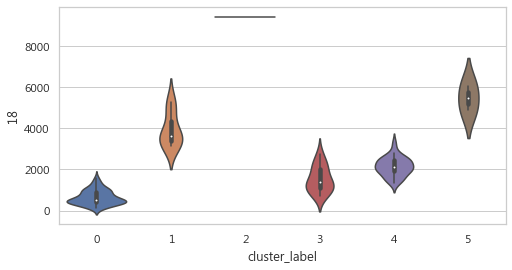

In [37]:
fig = plt.figure(figsize=(8,4))
sns.violinplot(x=stations_data['cluster_label'], y=stations_data.loc[:,18])
plt.show()

In [38]:
stations_data[stations_data['cluster_label'] == 5]

,Entrance,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,...,Normal_before,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,Cross_Lines,Lines_Transfer,Transportation,cluster_label
50,市政府,591.400000,0.565934,317.476712,1125.813699,1967.309589,1536.901370,1369.306849,1660.224658,2092.772603,...,3058.589416,2812.032509,2802.464323,2388.944004,2187.750700,1790.604167,0,0,0,5
96,西門,1100.468493,1.928571,684.301370,1905.690411,3806.238356,3025.772603,2956.268493,3266.750685,3594.191781,...,3506.478832,4029.078755,2652.023959,2786.253968,2146.801921,2207.865079,1,1,0,5


In [40]:
stations_data.to_csv('station_kmean_result.csv', index=False)

### Route Cluster Analysis

In [41]:
X = routes_data.drop(columns=['From_To','StationA','StationB'])
X.head()

,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,13_before,...,23,Normal_before,Weekend_before,Normal_covid,Weekend_covid,Normal,Weekend,TravelTime,DrivingTime,Distance(m)
0,2.408219,0.0,2.750685,13.142466,19.715068,9.739726,6.345205,6.367123,6.219178,6.934247,...,2.323353,9.012226,8.759158,4.744316,4.446208,3.380152,2.882937,29,20.200000,13542
1,2.315068,0.0,0.468493,0.805479,4.397260,2.928767,2.109589,2.424658,2.852055,3.649315,...,2.173653,5.125182,7.198260,4.308499,5.213404,3.126050,2.701389,32,20.900000,16150
2,3.139726,0.0,0.238356,1.794521,2.306849,2.627397,2.627397,2.704110,3.043836,3.547945,...,3.293413,5.172993,6.936813,4.436341,5.216931,3.136054,2.861111,36,23.066667,12839
3,0.564384,0.0,0.309589,0.504110,1.871233,1.249315,1.758904,1.452055,1.350685,1.660274,...,0.221557,1.067701,2.426740,0.462399,0.817901,0.328131,0.415675,28,16.316667,7797
4,1.561644,0.0,0.306849,0.830137,2.145205,2.189041,1.895890,2.315068,2.830137,2.882192,...,2.526946,4.612774,6.576465,3.636411,4.643298,2.593437,2.589286,30,18.900000,9468


In [42]:
distortions, silhouette_avg = [], []
for i in range(2,20):
    km = KMeans(n_clusters=i)
    km_fit = km.fit(X)
    distortions.append(km.inertia_)
    silhouette_avg.append(silhouette_score(X, km_fit.labels_))

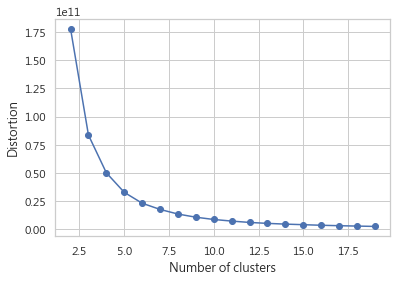

In [43]:
plt.plot(range(2,20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

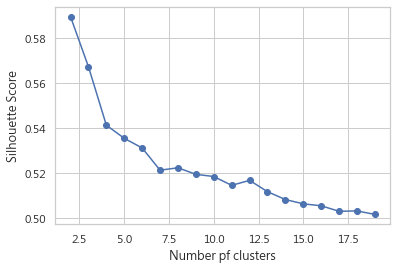

In [44]:
plt.plot(range(2,20), silhouette_avg, marker='o')
plt.xlabel('Number pf clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [51]:
km = KMeans(n_clusters=5)
y_km = km.fit_predict(X)

In [52]:
for i in set(y_km):
    print(i,len(X[y_km==i]))

0 2836
1 3230
2 935
3 2782
4 1773


In [53]:
routes_data['cluster_label'] = y_km

In [54]:
routes_data.head()

,0_before,5_before,6_before,7_before,8_before,9_before,10_before,11_before,12_before,13_before,...,Normal_covid,Weekend_covid,Normal,Weekend,StationA,StationB,TravelTime,DrivingTime,Distance(m),cluster_label
0,2.408219,0.0,2.750685,13.142466,19.715068,9.739726,6.345205,6.367123,6.219178,6.934247,...,4.744316,4.446208,3.380152,2.882937,BL板橋,七張,29,20.200000,13542,0
1,2.315068,0.0,0.468493,0.805479,4.397260,2.928767,2.109589,2.424658,2.852055,3.649315,...,4.308499,5.213404,3.126050,2.701389,BL板橋,三和國中,32,20.900000,16150,0
2,3.139726,0.0,0.238356,1.794521,2.306849,2.627397,2.627397,2.704110,3.043836,3.547945,...,4.436341,5.216931,3.136054,2.861111,BL板橋,三民高中,36,23.066667,12839,0
3,0.564384,0.0,0.309589,0.504110,1.871233,1.249315,1.758904,1.452055,1.350685,1.660274,...,0.462399,0.817901,0.328131,0.415675,BL板橋,三重,28,16.316667,7797,1
4,1.561644,0.0,0.306849,0.830137,2.145205,2.189041,1.895890,2.315068,2.830137,2.882192,...,3.636411,4.643298,2.593437,2.589286,BL板橋,三重國小,30,18.900000,9468,1


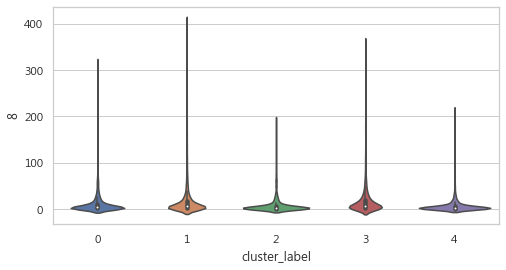

In [55]:
mpl.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(8,4))
sns.violinplot(x=routes_data['cluster_label'], y=routes_data.loc[:,8])
plt.show()

In [56]:
routes_data[routes_data['cluster_label'] == 1][['StationA', 'StationB',7,8,9,17,18,19]].sort_values(by=8, ascending=False).head(10)

,StationA,StationB,7,8,9,17,18,19
3473,台北車站,市政府,171.491018,403.850299,287.257485,280.598802,314.844311,226.227545
3453,台北車站,台北101/世貿,70.125749,272.634731,241.341317,122.808383,141.221557,103.293413
11202,頂溪,松江南京,96.137725,264.341317,111.502994,26.700599,29.544910,17.479042
6559,新埔,台北車站,125.634731,264.227545,123.197605,91.946108,92.706587,45.125749
2876,南港展覽館,西湖,75.664671,238.730539,130.257485,17.688623,30.359281,18.161677
8206,永安市場,松江南京,80.239521,234.365269,88.209581,21.065868,28.227545,14.814371
2831,南港展覽館,市政府,98.694611,222.940120,166.299401,128.562874,209.485030,122.994012
2863,南港展覽館,港墘,119.377246,217.287425,86.664671,23.988024,42.227545,22.203593
7242,景安,松江南京,86.880240,217.059880,83.395210,19.371257,25.419162,16.137725
9653,萬芳醫院,南京復興,68.035928,195.754491,87.532934,39.479042,36.341317,18.826347


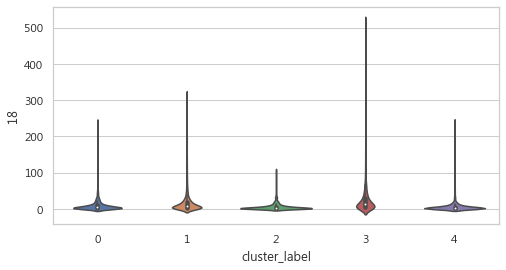

In [57]:
fig = plt.figure(figsize=(8,4))
sns.violinplot(x=routes_data['cluster_label'], y=routes_data.loc[:,18])
plt.show()

In [59]:
routes_data[routes_data['cluster_label'] == 3][['StationA', 'StationB',7,8,9,17,18,19]].sort_values(by=18, ascending=False).head(10)

,StationA,StationB,7,8,9,17,18,19
5382,市政府,台北車站,85.670659,123.311377,96.538922,432.119760,514.191617,345.868263
10304,西門,台北車站,65.239521,92.610778,85.317365,422.904192,398.191617,315.239521
3134,台北101/世貿,台北車站,55.035928,71.706587,51.143713,247.089820,354.431138,218.874251
3519,台北車站,西門,52.023952,144.101796,143.293413,311.970060,336.395210,261.047904
6024,忠孝敦化,台北車站,39.497006,59.892216,45.724551,216.700599,305.700599,199.437126
6131,忠孝新生,台北車站,44.658683,67.047904,46.946108,272.161677,288.167665,163.532934
5917,忠孝復興,台北車站,51.383234,63.305389,52.329341,257.796407,287.622754,231.167665
5375,市政府,南港,54.586826,63.544910,43.000000,218.862275,273.155689,200.964072
2532,南京復興,松山,25.754491,47.586826,35.616766,148.185629,271.880240,144.976048
5405,市政府,忠孝敦化,30.023952,66.892216,61.317365,196.778443,270.598802,198.497006


In [60]:
routes_data.to_csv('route_kmean_result.csv', index=False)